In [2]:
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import pandas as pd
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')

def preprocess_text(text):
    # Tokenização
    tokens = word_tokenize(text)
    
    # Remoção de pontuações e transformação em minúsculas
    clean_tokens = [token.lower() for token in tokens if re.match(r'^[a-zA-Z]+$', token)]
    
    # Remoção de stopwords
    filtered_tokens = [token for token in clean_tokens if token not in stopwords.words('english')]
    
    clean_text = ' '.join(filtered_tokens)
    return clean_text

# Exemplo de texto
text = "This is an example sentence. It includes various words and punctuation."

# Pré-processar o texto usando a função
preprocessed_text = preprocess_text(text)
print(preprocessed_text)

example sentence includes various words punctuation


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\vh_co\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\vh_co\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vh_co\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<Axes: xlabel='overall'>

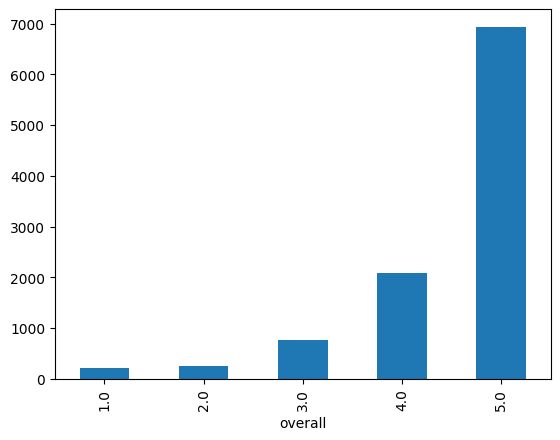

In [9]:
ds = pd.read_csv('./Musical_instruments_reviews.csv')
ds['overall'].value_counts().sort_index().plot.bar()


In [10]:
print(ds.overall.value_counts())
print(ds.columns)
print(ds.shape)
#Removendo valores nulos
print(ds.isnull().sum())
ds = ds.dropna()

#Tranformando coluna de avaliações em binário 1 para bom e 0 para ruim
ds['overall'] = ds['overall'].apply(lambda x: 1 if x > 3 else 0)
print(ds.overall.value_counts())

#Diminuir o tamanho do dataset
q1 = ds[ds.overall == 0].sample(1200)
q2 = ds[ds.overall == 1].sample(1200)

ds = pd.concat([q1, q2], axis=0)
print(ds.overall.value_counts())
print(ds.columns)
print(ds.shape)



overall
5.0    6938
4.0    2084
3.0     772
2.0     250
1.0     217
Name: count, dtype: int64
Index(['reviewerID', 'asin', 'reviewerName', 'helpful', 'reviewText',
       'overall', 'summary', 'unixReviewTime', 'reviewTime'],
      dtype='object')
(10261, 9)
reviewerID         0
asin               0
reviewerName      27
helpful            0
reviewText         7
overall            0
summary            0
unixReviewTime     0
reviewTime         0
dtype: int64
overall
1    8991
0    1236
Name: count, dtype: int64
overall
0    1200
1    1200
Name: count, dtype: int64
Index(['reviewerID', 'asin', 'reviewerName', 'helpful', 'reviewText',
       'overall', 'summary', 'unixReviewTime', 'reviewTime'],
      dtype='object')
(2400, 9)


In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(ds.reviewText, ds.overall, test_size=0.2, random_state=42)

#Tokenizando os textos utilizando BOW
from sklearn.feature_extraction.text import CountVectorizer
v = CountVectorizer()
print(X_train)
X_train_bow = v.fit_transform(X_train.values)
X_train_bow.toarray()[:3]



5864    a little small for my hands, but the kids that...
2312    This is an OK solution to keeping your picks h...
1096    I like replacing pickguards, truss rod covers,...
5313    This cable is quality, no crackling, strong co...
5479    I heard great things about the S6 and so, bein...
                              ...                        
5554    Very easy to get the guitar into and seems to ...
3512    I am a converted guitar player and I like play...
4403    I like this product, but wish it had a wider f...
8325    It works.  It is cheap.  It does the job well....
9831    It is okay. It serves the purpose. It is a goo...
Name: reviewText, Length: 1920, dtype: object


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [12]:
#Utilizando o método de Naive Bytes
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB()
model.fit(X_train_bow, y_train)


MultinomialNB()

In [13]:
#Testando o modelo
X_test_bow = v.transform(X_test)
model.score(X_test_bow, y_test)

0.7020833333333333

In [14]:
#Tokenização dos textos utilizando o tensorflow
# Inicialização do Tokenizer
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train.values)

# Tokenização dos textos
textos_tokenizados = tokenizer.texts_to_sequences(X_train.values)

print("Textos tokenizados:", textos_tokenizados[1])

Textos tokenizados: [10, 7, 43, 263, 1319, 5, 907, 47, 101, 688, 4, 3306, 35, 340, 12, 44, 18, 25, 265, 225, 12, 44, 176, 3, 135, 21, 3307, 5, 280, 56, 5454, 40, 129, 1, 803, 4, 14, 238, 143, 13, 3, 177, 5455, 54, 89, 32, 21, 49, 282, 12, 18, 5, 46, 5, 25, 14, 3, 2267, 15, 388, 542, 1247, 15, 1, 823, 4, 264, 8, 1, 135, 33, 191, 5, 46, 1, 135, 38, 8, 1, 558, 4, 23, 12, 34, 150, 60, 55, 1, 337, 993, 1183, 6, 6, 65, 43, 1892, 2062, 24, 2, 422, 12, 44, 610, 6, 15, 47, 72, 22, 643, 177, 5456, 13, 240, 411, 19]


In [16]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense

# Hiperparâmetros
vocab_size = X_train_bow.shape[1]  # Tamanho do vocabulário
embedding_dim = 32  # Dimensão da camada de incorporação

print(X_train_bow.shape)

# Modelo RNN com Embedding Layer
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim),
    SimpleRNN(128),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train_bow.toarray(), y_train, epochs=2)




(1920, 9741)
Epoch 1/2
 2/60 [>.............................] - ETA: 9:27 - loss: 0.7165 - accuracy: 0.3438 

KeyboardInterrupt: 

In [11]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = np.argmax(model.predict(X_test_bow), axis=-1)

print(classification_report(y_test, y_pred)) 


15/15 [==============================] - 6s 403ms/step
              precision    recall  f1-score   support

           0       0.52      1.00      0.68       248
           1       0.00      0.00      0.00       232

    accuracy                           0.52       480
   macro avg       0.26      0.50      0.34       480
weighted avg       0.27      0.52      0.35       480



c:\Users\vh_co\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\vh_co\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\vh_co\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [12]:
# Modelo LSTM Unidirecional com Embedding Layer
from tensorflow.keras.layers import Embedding, LSTM, Dense
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim),
    LSTM(64),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train_bow.toarray(), y_train, epochs=3)

Epoch 1/3
60/60 [==============================] - 1143s 19s/step - loss: 0.6939 - accuracy: 0.5000
Epoch 2/3
60/60 [==============================] - 714s 12s/step - loss: 0.6936 - accuracy: 0.4917
Epoch 3/3
60/60 [==============================] - 592s 10s/step - loss: 0.6933 - accuracy: 0.4948


In [13]:
y_pred = np.argmax(model.predict(X_test_bow), axis=-1)

print(classification_report(y_test, y_pred)) 

15/15 [==============================] - 20s 1s/step
              precision    recall  f1-score   support

           0       0.52      1.00      0.68       248
           1       0.00      0.00      0.00       232

    accuracy                           0.52       480
   macro avg       0.26      0.50      0.34       480
weighted avg       0.27      0.52      0.35       480



c:\Users\vh_co\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\vh_co\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\vh_co\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [14]:
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim),
    Bidirectional(LSTM(128)),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train_bow.toarray(), y_train, epochs=3)

Epoch 1/3
43/60 [====================>.........] - ETA: 4:13 - loss: 0.6939 - accuracy: 0.4942

In [ ]:
y_pred = np.argmax(model.predict(X_test_bow), axis=-1)

print(classification_report(y_test, y_pred))  